# 課題
- 国勢調査等の各種データから、地域の現在の特徴を明らかにすることができます。
- そこで、さいたま市（もしくは埼玉県）の現在の特徴をデータに基づき説明してください。
- そして、将来（5～10年後）のあるべき姿を策定し、その実現に向けて必要な施策を提案してください。また施策の効果を定量的に考察してください。

## 参考
- 統計センター SSDSE（教育用標準データセット）
  - https://www.nstac.go.jp/use/literacy/ssdse/
- 気象庁 過去の気象データ・ダウンロード
  - https://www.data.jma.go.jp/gmd/risk/obsdl/index.php
- 埼玉県 彩の国 統計情報館
  - https://www.pref.saitama.lg.jp/theme/tokei/

## レポート作成上の注意
- 内容を要約したタイトルをつけること
  - テーマは、人口問題、気象変動、家計消費、観光、住宅、学校など、興味のあるテーマを自由に設定してください
- 分析したデータの概要を記述し、その選択根拠を示すこと
- 表・グラフ等を利用して、わかりやすく説明すること
- オリジナリティのある提案を行い、定量的に考察すること
- 参考資料、引用文献に関する情報を適切に記載すること

レポートは A4 2ページ程度にまとめ、ファイルで提出

# 解答の方向性
## 埼玉の現在の状況を分析
- 全国の看護師数，高齢者数，介護者数と比較
- 増加傾向にあるかどうか
- 比率で調査
- 
- 時系列分析(自己回帰モデル: ARIMA，LSTM)から10年後の要介護者数と介護士の数を推定
- 行政，介護老人ホーム等の定める要介護者数と介護士の比率から，状況を判断する
  - ひとりあたりの負担の定量化
  - 残業時間，有給消化率などから労働条件の分析
  - 行政の指針とは別に自分なりの指標を算出
- 介護士資格の受験者数，合格率

## 将来のあるべき姿の策定及び政策の提案・効果の定量的評価
- 介護士の育成費を向上させる
- AI，ロボットを活用した介護体制の充足
  - 介護士一人当たりのキャパを増やす
- フェルミ推定で効果の評価


## 参考
- [厚生労働省 衛生行政報告例](https://www.e-stat.go.jp/stat-search/files?page=1&toukei=00450027&tstat=000001031469)
- [厚生労働省 介護保険事業状況報告](https://www.mhlw.go.jp/topics/kaigo/osirase/jigyo/m23/2301.html)
- [看護師統計資料](https://www.nurse.or.jp/nursing/statistics_publication/statistics/)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
from glob import glob
from tqdm import tqdm

## データの読み込み
### データセットの作成
- 統計センターの教育用データセットから，65歳以上の人口の推移を抽出(2009～2020)
- 衛生行政報告書から看護師に関する10年分(2002年～2020年で隔年)のデータを保存
- 介護保険事業状況報告から，要介護者数を抽出(2009～2020)，12月を年度の代表値とした．

In [2]:
total_dataset = []
saitama_dataset = []

#### 65歳以上の人口

In [3]:
df_num = pd.read_excel("data/SSDSE-B-2023.xlsx", skiprows=1)

# 全国の総人口と高齢者数，高齢者率を計算
df_total = df_num.groupby("年度").sum().loc[:, ["総人口", "65歳以上人口"]]
df_total["高齢者率"] = df_total["65歳以上人口"] / df_total["総人口"]

total_dataset.append(df_total)

# 埼玉県の人口と高齢者数，高齢者率を計算
df_saitama = df_num[df_num["都道府県"] == "埼玉県"]
df_saitama.index = df_saitama["年度"]
df_saitama = df_saitama.loc[:, ["総人口", "65歳以上人口"]]
df_saitama["高齢者率"] = df_saitama["65歳以上人口"] / df_saitama["総人口"]
saitama_dataset.append(df_saitama)

#### 看護師数
- 訪問介護ステーションの従業員，介護保険施設もしくは老人福祉施設に所属している看護師を介護に携わる看護師とする
- 隔年調査のため，線形補完する

In [4]:
data_sum = glob("data/*_sum.csv")
data_loc = glob("data/*_loc.csv")
print(len(data_sum), len(data_loc))

10 10


In [5]:
names=["都道府県", "保健師", "助産師", "看護師", "准看護師", "保健師(/10万人)", "助産師(/10万人)", "看護師(/10万人)", "准看護師(/10万人)"]
total_index = ["　　全　国", "全　国", "全国"]
saitama_index = ["11　埼　玉", "埼　玉", "埼玉", "埼玉県"]

total_kangoshi = {}
saitama_kangoshi = {}

for i, file_name in enumerate(data_sum):
    _df = pd.read_csv(
        data_sum[i], skiprows=[0, 1, 2],
        names=names,
        encoding="shift-jis"
    )
    _df.replace("_", 0)
    
    total = _df[_df["都道府県"].isin(total_index)]["看護師"].values[0]
    saitama = _df[_df["都道府県"].isin(saitama_index)]["看護師"].values[0]
    year = re.search(r"\d{4}", file_name).group()
    total_kangoshi[int(year)] = {"看護師数": int(total)}
    saitama_kangoshi[int(year)] = {"看護師数": int(saitama)}

In [6]:
for i, file_name in enumerate(data_loc):
    _df = pd.read_csv(
        data_loc[i], skiprows=[0, 1, 2, 3, 4, 5, 6],
        usecols=[0, 9, 10, 11, 12, 13, 14],
        names=[
            "都道府県", "訪問介護ステーション(従業員)", 
            "介護保険施設(保健施設)", "介護保険施設(指定介護施設)", "介護保険施設(居宅サービス)", "介護保険施設(居宅介護支援)", 
            "社会福祉施設(老人福祉)"
        ],
        encoding="shift-jis"
    )
    _df.replace("_", 0)

    total = _df[_df["都道府県"].isin(total_index)].iloc[:, 1:].astype(int).sum(axis="columns")
    saitama = _df[_df["都道府県"].isin(saitama_index)].iloc[:, 1:].astype(int).sum(axis="columns")
    year = re.search(r"\d{4}", file_name).group()
    # print(year, total.to_numpy()[0], saitama.to_numpy()[0])
    total_kangoshi[int(year)]["介護に携わる人"] = total.to_numpy()[0]
    saitama_kangoshi[int(year)]["介護に携わる人"] = saitama.to_numpy()[0]


In [7]:
df_kangosi_total = pd.DataFrame(total_kangoshi).T
df_kangosi_saitama = pd.DataFrame(saitama_kangoshi).T
# 線形補完
years = df_kangosi_total.index
for i in range(len(years) - 1):
    df_kangosi_total.loc[2003+i*2] = ((df_kangosi_total.iloc[i, :] + df_kangosi_total.iloc[i+1, :]) / 2).astype(int)
    df_kangosi_saitama.loc[2003+i*2] = ((df_kangosi_saitama.iloc[i, :] + df_kangosi_saitama.iloc[i+1, :]) / 2).astype(int)
        
# df_kangosi_saitama

#### 要介護者数

In [8]:
requiring_data = glob("data/20??_kaigo.xls*")
total_require_dict = {}
saitama_require_dict = {}

for i, file_name in enumerate(requiring_data[:3]):
    df_require = pd.read_excel(
        requiring_data[i], skiprows=[0, 1, 2, 3], header=1 # , usecols=[0, 9], names=["都道府県", "要介護者数"]
    ).dropna()

    year = re.search(r"\d{4}", file_name).group()
    require_total = df_require[df_require["Unnamed: 0"] == "全国計"]["合計"].astype(int).to_numpy()[0]
    require_saitama = df_require[df_require["Unnamed: 0"] == "埼玉県"]["合計"].astype(int).to_numpy()[0]

    total_require_dict[int(year)] = {"要介護者数": require_total}
    saitama_require_dict[int(year)] = {"要介護者数":require_saitama}
    
    # print(year, require_total, require_saitama)
    
for i, file_name in enumerate(requiring_data[3:]):
    index = i+3
    df_require = pd.read_excel(
        requiring_data[index], skiprows=[0, 1, 2, 3], header=0 # , usecols=[0, 9], names=["都道府県", "要介護者数"]
    ).dropna()

    year = re.search(r"\d{4}", file_name).group()
    require_total = df_require[df_require["Unnamed: 0"] == "全国計"]["合計"].astype(int).to_numpy()[0]
    require_saitama = df_require[df_require["Unnamed: 0"] == "埼玉県"]["合計"].astype(int).to_numpy()[0]

    total_require_dict[int(year)] = {"要介護者数": require_total}
    saitama_require_dict[int(year)] = {"要介護者数":require_saitama}
    
    # print(year, require_total, require_saitama)

In [9]:
df_req_total = pd.DataFrame(total_require_dict).T
df_req_saitama = pd.DataFrame(saitama_require_dict).T

#### データセットを保存

In [10]:
ds_total = pd.concat([df_total, df_kangosi_total, df_req_total], axis=1).dropna()
ds_saitama = pd.concat([df_saitama, df_kangosi_saitama, df_req_saitama], axis=1).dropna()

ds_total = ds_total.sort_index()
ds_saitama = ds_saitama.sort_index()

ds_total.to_csv("dataset-total.csv")
ds_saitama.to_csv("dataset-saitama.csv")

## 現状の分析
### 可視化

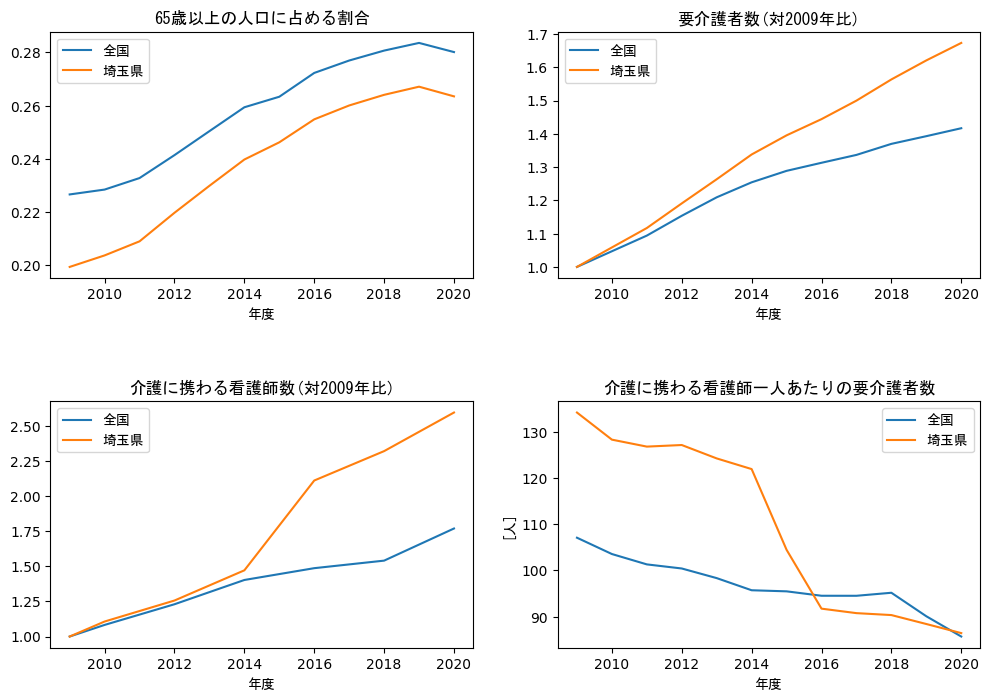

In [11]:
fig = plt.figure(figsize=(12, 8))
ax = [fig.add_subplot(2, 2, i+1) for i in range(4)]
fig.subplots_adjust(hspace=0.5)

x = ds_total.index

# 高齢者率をプロット
y1 = ds_total["高齢者率"]
y2 = ds_saitama["高齢者率"]

ax[0].plot(x, y1, label="全国")
ax[0].plot(x, y2, label="埼玉県")
ax[0].set_title("65歳以上の人口に占める割合", family="MS Gothic")

# 要介護者数をプロット
y1 = ds_total["要介護者数"] / ds_total.loc[2009 ,"要介護者数"]
y2 = ds_saitama["要介護者数"] / ds_saitama.loc[2009, "要介護者数"]
# ax_twin = ax[1].twinx()

ax[1].plot(x, y1, label="全国")
ax[1].plot(x, y2, label="埼玉県")

ax[1].set_title("要介護者数(対2009年比)", family="MS Gothic")
# handler1, label1 = ax[1].get_legend_handles_labels()
# handler2, label2 = ax_twin.get_legend_handles_labels()
# ax[1].legend(handler1+label1, handler2+label2, loc=2, prop={"family": "MS Gothic"})


# 介護に携わる看護師数をプロット
y1 = ds_total["介護に携わる人"] / ds_total.loc[2009, "介護に携わる人"]
y2 = ds_saitama["介護に携わる人"] / ds_saitama.loc[2009, "介護に携わる人"]

ax[2].plot(x, y1, label="全国")
ax[2].plot(x, y2, label="埼玉県")
ax[2].set_title("介護に携わる看護師数(対2009年比)", family="MS Gothic")

# 要介護者と看護師の比率をプロット
y1 = ds_total["要介護者数"] / ds_total["介護に携わる人"]
y2 = ds_saitama["要介護者数"] / ds_saitama["介護に携わる人"]

ax[3].plot(x, y1, label="全国")
ax[3].plot(x, y2, label="埼玉県")

ax[3].set_title("介護に携わる看護師一人あたりの要介護者数", family="MS Gothic")
ax[3].set_ylabel("[人]", family="MS Gothic")
# ax[2].legend(prop={"family": "MS Gothic"})

for i in ax:
    i.set_xlabel("年度", family="MS Gothic")
    i.legend(prop={"family": "MS Gothic"})

plt.show()